In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/.local/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/edgaregurrola/.local/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [2]:
df = pd.read_csv('../../data/processed/airbnb/QueryA.csv')
print(df.shape)
df.head(4)

(12413, 16)


,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,35797.0,Villa Dante,153786,Dici,Cuajimalpa de Morelos,19.38283,-99.27178,Entire home/apt,4001,1,0,NaN,NaN,1,363,0
1,44616.0,CONDESA HAUS B&B,196253,Condesa Haus Bed & Breakfast CDMX,Cuauhtémoc,19.41162,-99.17794,Entire home/apt,18000,1,58,29/08/2022,0.44,12,331,8
2,56074.0,Great space in historical San Rafael,265650,Maris,Cuauhtémoc,19.43977,-99.15605,Entire home/apt,650,2,76,08/09/2022,0.54,2,354,15
3,817291.0,Live Mexico City Like a Small Town,4017148,Alberto & Lu,Benito Juárez,19.38468,-99.17708,Entire home/apt,740,2,61,31/10/2021,0.51,1,314,1


<AxesSubplot:>

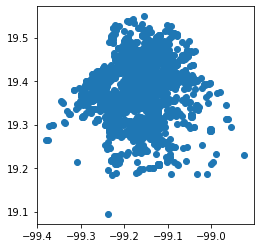

In [4]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.plot()

<AxesSubplot:>

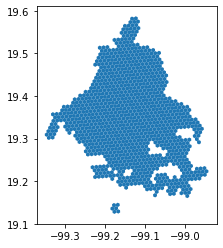

In [5]:
gdf_cdmx = aup.gdf_from_db('participacion_cdmx_hexres8', 'governance')
gdf_cdmx.plot()

In [6]:
hex_id = list(gdf_cdmx.hex_id_8.unique())

In [9]:
censo_folder = 'censo' 
censo_table = 'hex_censo_mza_2020_res8'

censo_query = f"SELECT hex_id_8, vivtot, tvivparhab, geometry FROM {censo_folder}.{censo_table} WHERE hex_id_8 IN {str(tuple(hex_id))}"
hex_censo = aup.gdf_from_query(censo_query, geometry_col="geometry", index_col="hex_id_8")

In [10]:
print(hex_censo.shape)
hex_censo.head(2)

(1097, 3)


,vivtot,tvivparhab,geometry
hex_id_8,,,
884995b819fffff,5084.0,4396.0,"POLYGON ((-99.16618 19.45738, -99.16166 19.460..."
88499584a1fffff,1668.0,1525.0,"POLYGON ((-99.17742 19.34787, -99.17290 19.350..."


<AxesSubplot:>

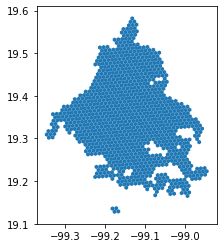

In [11]:
hex_censo.plot()

In [13]:
gdf = gdf.set_crs("EPSG:4326")

In [17]:
hex_airbnb = gdf.sjoin(hex_censo)

In [37]:
print(hex_airbnb.shape)
hex_airbnb.head(4)

(12210, 20)


,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,geometry,index_right,vivtot,tvivparhab
0,35797.0,Villa Dante,153786,Dici,Cuajimalpa de Morelos,19.38283,-99.27178,Entire home/apt,4001,1,0,NaN,NaN,1,363,0,POINT (-99.27178 19.38283),884995b15bfffff,861.0,810.0
1,44616.0,CONDESA HAUS B&B,196253,Condesa Haus Bed & Breakfast CDMX,Cuauhtémoc,19.41162,-99.17794,Entire home/apt,18000,1,58,29/08/2022,0.44,12,331,8,POINT (-99.17794 19.41162),884995ba03fffff,5879.0,4921.0
5,824016.0,Suite 5 - Suites Condesa Mexico,4326326,Rodrigo,Cuauhtémoc,19.40915,-99.17321,Entire home/apt,900,30,46,07/11/2019,0.41,6,206,0,POINT (-99.17321 19.40915),884995ba03fffff,5879.0,4921.0
6,826691.0,Suite 7 - Suites Condesa Mexico,4326326,Rodrigo,Cuauhtémoc,19.40915,-99.17321,Entire home/apt,850,180,18,11/05/2019,0.17,6,326,0,POINT (-99.17321 19.40915),884995ba03fffff,5879.0,4921.0


In [21]:
hex_airbnb_group = hex_airbnb.groupby('index_right').count()
hex_airbnb_group.reset_index(inplace=True)
hex_airbnb_group = hex_airbnb_group[['index_right','id']]
hex_airbnb_group = hex_airbnb_group.rename(columns={'index_right':'hex_id_8',
                                                   'id':'airbnb_count'})
hex_airbnb_group.head(2)

,hex_id_8,airbnb_count
0,88499516dbfffff,3
1,8849958009fffff,1


In [27]:
hex_censo_airbnb = hex_censo.merge(hex_airbnb_group, on='hex_id_8', how='left')
print(hex_censo_airbnb.shape)
hex_censo_airbnb.head(2)

(1097, 5)


,hex_id_8,vivtot,tvivparhab,geometry,airbnb_count
0,884995b819fffff,5084.0,4396.0,"POLYGON ((-99.16618 19.45738, -99.16166 19.460...",9.0
1,88499584a1fffff,1668.0,1525.0,"POLYGON ((-99.17742 19.34787, -99.17290 19.350...",11.0


In [30]:
hex_censo_airbnb['pct_airbnb'] = hex_censo_airbnb['airbnb_count'] / hex_censo_airbnb['vivtot']

In [32]:
idx = hex_censo_airbnb['pct_airbnb'].isna()
hex_censo_airbnb.loc[idx,'pct_airbnb'] = 0

In [33]:
sns.set_style("whitegrid")

(-99.37009166728625,
 -98.92170403279144,
 19.099845986262867,
 19.609901301311126)

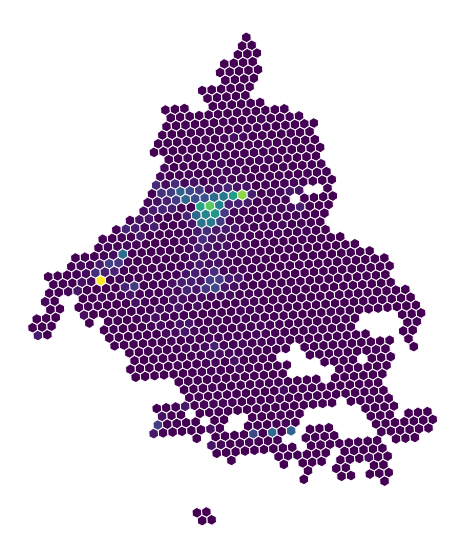

In [34]:
fig, ax = plt.subplots(figsize=(10,10))


hex_censo_airbnb.plot('pct_airbnb',ax=ax, cmap='viridis')

ax.axis('off')

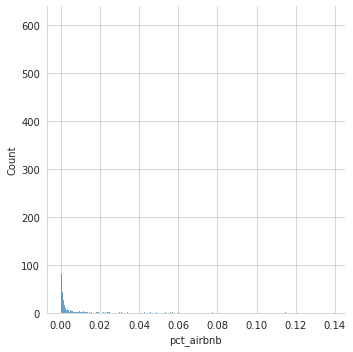

In [35]:
sns.displot(hex_censo_airbnb['pct_airbnb'])

In [36]:
hex_censo_airbnb.to_file('../../data/processed/airbnb/AirBnB_CDMX.geojson', driver='GeoJSON')